# Exploratory Data Analysis - Preprocessing


In [1]:
import pandas as pd
from textblob import TextBlob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows (adjust if needed, can use 'None' for no limit)
pd.set_option('display.max_rows', None)

# Set the maximum width of each column (adjust if needed)
pd.set_option('display.max_colwidth', None)

In [4]:
def load_movie_lines(lines_file_path):
    lines = {}
    with open(lines_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) == 5:
                line_id, character_id, movie_id, character_name, text = parts
                lines[line_id] = {
                    "character_id": character_id,
                    "movie_id": movie_id,
                    "character_name": character_name,
                    "text": text
                }
    return lines


In [5]:
def load_movie_conversations(conversations_file_path):
    conversations = []
    with open(conversations_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) == 4:
                character1_id, character2_id, movie_id, utterance_ids = parts
                utterance_ids = utterance_ids[1:-1].replace("'", "").split(', ')
                conversations.append({
                    "character1_id": character1_id,
                    "character2_id": character2_id,
                    "movie_id": movie_id,
                    "utterances": utterance_ids
                })
    return conversations

In [6]:
def load_movie_metadata(metadata_file_path):
    movie_metadata = {}
    with open(metadata_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) > 5:
                movie_id, title, genre = parts[0], parts[1], parts[5]
                movie_metadata[movie_id] = genre
    return movie_metadata

In [7]:
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

In [8]:
# lines_file = "./Cornell_Movie_Dialogue_Corpus/movie_lines.txt"
# conversation_file = "./Cornell_Movie_Dialogue_Corpus/movie_conversations.txt"
# metadata_file = "./Cornell_Movie_Dialogue_Corpus/movie_titles_metadata.txt"
lines_file = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/Cornell_Movie_Dialogue_Corpus/movie_lines.txt"
conversation_file = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/Cornell_Movie_Dialogue_Corpus/movie_conversations.txt"
metadata_file = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/Cornell_Movie_Dialogue_Corpus/movie_titles_metadata.txt"

lines = load_movie_lines(lines_file)
conversations = load_movie_conversations(conversation_file)
movie_metadata = load_movie_metadata(metadata_file)

In [16]:
# Build character ID to name mapping
character_id_to_name = {}

for line in lines.values():
    character_id = line['character_id']
    character_name = line['character_name']
    character_id_to_name[character_id] = character_name

# Initialize empty list to store conversation data
data = []

# Define a special token for empty history
EMPTY_HISTORY_TOKEN = "[START]"

# Loop through each conversation block
for conv in conversations:
    utterance_ids = conv['utterances']
    character1_id = conv['character1_id']
    character2_id = conv['character2_id']
    character1_name = character_id_to_name.get(character1_id)
    character2_name = character_id_to_name.get(character2_id)

    # Skip conversation if character names are missing
    if not character1_name or not character2_name:
        continue

    # Initialize full conversation history
    full_conversation_history = []

    # Loop through the utterances to build conversation history and response for each block
    for i in range(len(utterance_ids)):
        response_id = utterance_ids[i]  # Current response ID

        # Ensure the response_id is in the lines dictionary
        if response_id in lines:
            response_line = lines[response_id]
            response = response_line['text']
            character_2 = response_line['character_name']  # Current speaker

            # Determine character_1 as the other character in the conversation
            if character_2 == character1_name:
                character_1 = character2_name
            else:
                character_1 = character1_name

            # Build the conversation history including all previous utterances
            history_ids = utterance_ids[:i]  # Include all previous utterances

            # Check if history is empty
            if not history_ids:
                conversation_history = [EMPTY_HISTORY_TOKEN]
            else:
                conversation_history = [lines[utt_id]['text'] for utt_id in history_ids if utt_id in lines]

            # Determine the history length, setting it to 0 if [START] is in conversation_history
            if conversation_history == [EMPTY_HISTORY_TOKEN]:
                history_length = 0
            else:
                history_length = len(conversation_history)

            # Append the conversation and its context to the data
            data.append({
                "movie_id": conv['movie_id'],
                "character_1": character_1,  # Person being addressed
                "character_2": character_2,  # Current speaker
                "conversation_history": conversation_history,
                "history_length": history_length,
                "response": response,
                "genre": movie_metadata.get(conv['movie_id'], [])
            })

            # Update full conversation history
            full_conversation_history.append(response)
        else:
            continue  # Skip if the response_id is missing in lines


In [17]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Add Genre as meta data
df['genre'] = df['movie_id'].map(movie_metadata)

# Add sentiment to response
df['sentiment'] = df['response'].apply(get_sentiment)

# Display the DataFrame
#df.head(130:140)
df.iloc[128:141]

,movie_id,character_1,character_2,conversation_history,history_length,response,genre,sentiment
128,m0,BIANCA,KAT,[[START]],0,"Joey never told you we went out, did he?","['comedy', 'romance']",0.0
129,m0,KAT,BIANCA,"[Joey never told you we went out, did he?]",1,What?,"['comedy', 'romance']",0.0
130,m0,BIANCA,KAT,"[Joey never told you we went out, did he?, What?]",2,In 9th. For a month,"['comedy', 'romance']",0.0
131,m0,KAT,BIANCA,"[Joey never told you we went out, did he?, What?, In 9th. For a month]",3,Why?,"['comedy', 'romance']",0.0
132,m0,BIANCA,KAT,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?]",4,"He was, like, a total babe","['comedy', 'romance']",0.0
133,m0,KAT,BIANCA,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?, He was, like, a total babe]",5,But you hate Joey,"['comedy', 'romance']",-0.8
134,m0,BIANCA,KAT,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?, He was, like, a total babe, But you hate Joey]",6,"Now I do. Back then, was a different story.","['comedy', 'romance']",0.0
135,m0,KAT,BIANCA,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?, He was, like, a total babe, But you hate Joey, Now I do. Back then, was a different story.]",7,As in...,"['comedy', 'romance']",0.0
136,m0,BIANCA,KAT,[[START]],0,He said everyone was doing it. So I did it.,"['comedy', 'romance']",0.0
137,m0,KAT,BIANCA,[He said everyone was doing it. So I did it.],1,You did what?,"['comedy', 'romance']",0.0


# EDA

In [18]:
#import matplotlib as plt
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import seaborn as sns
import ast
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Set seaborn style
sns.set_theme(style='whitegrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304360 entries, 0 to 304359
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movie_id              304360 non-null  object 
 1   character_1           304360 non-null  object 
 2   character_2           304360 non-null  object 
 3   conversation_history  304360 non-null  object 
 4   history_length        304360 non-null  int64  
 5   response              304360 non-null  object 
 6   genre                 304360 non-null  object 
 7   sentiment             304360 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 18.6+ MB


In [20]:
# Convert Pandas DataFrame to Dask DataFrame
# Dask was needed due to the complexity with the conversations and its ability to parallel
ddf = dd.from_pandas(df, npartitions=10)  # Adjust npartitions based on system capacity

# Enable progress bar to monitor the process
with ProgressBar():
    # Run describe on all columns, including text-heavy ones
    summary = ddf.describe(include='all').compute()

# Display the summary statistics
print(summary)

[########################################] | 100% Completed | 1.82 s
       movie_id character_1 character_2 conversation_history  history_length  \
unique      617        5353        5353               213944             NaN   
count    304360      304360      304360               304360   304360.000000   
top        m289        JACK        JACK          ['[START]']             NaN   
freq       1530        3069        3032                82989             NaN   
mean       <NA>        <NA>        <NA>                 <NA>        2.470541   
std        <NA>        <NA>        <NA>                 <NA>        3.713879   
min        <NA>        <NA>        <NA>                 <NA>        0.000000   
25%        <NA>        <NA>        <NA>                 <NA>        0.000000   
50%        <NA>        <NA>        <NA>                 <NA>        1.000000   
75%        <NA>        <NA>        <NA>                 <NA>        3.000000   
max        <NA>        <NA>        <NA>            

The dataset highlights brief interaction patterns and a diversity of responses, which are crucial for training models to understand and generate contextually appropriate dialogue. With a wide variety of genres and character dynamics represented, particularly from dramatic contexts, the model can be better equipped to manage nuanced and emotionally varied conversations, reflecting real-world scenarios.

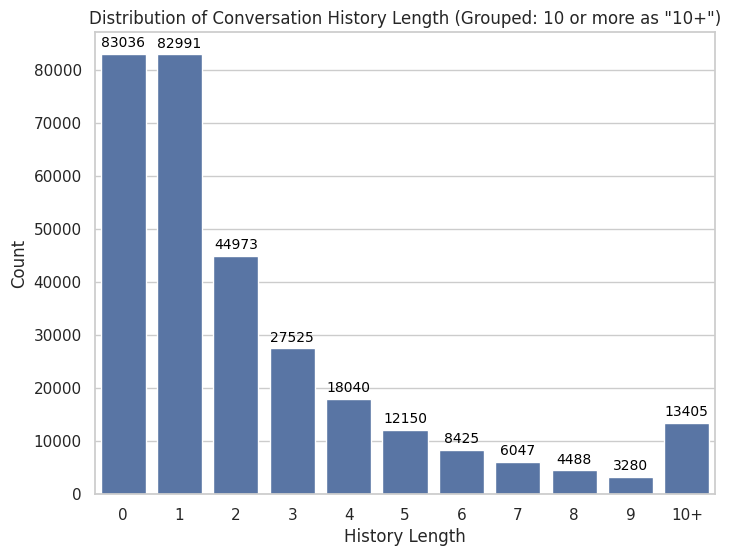

In [22]:
# Step 1: Correct history length for true zero-length histories (conversation_history == [] and response is not empty)
df['history_length'] = df.apply(lambda row: 0 if row['conversation_history'] == [] and row['response'].strip() != '' else row['history_length'], axis=1)

# Step 2: Exclude entries where conversation history is ["START"]
filtered_df = df[df['conversation_history'].apply(lambda x: x != ["START"])]

# Step 3: Group history lengths of 10 or more into "10+"
filtered_df['history_length_grouped'] = filtered_df['history_length'].apply(lambda x: str(x) if x < 10 else '10+')

# Step 4: Plot the distribution of conversation history lengths (grouped)
plt.figure(figsize=(8, 6))
sns_plot = sns.countplot(x='history_length_grouped', data=filtered_df, order=[str(i) for i in range(10)] + ['10+'])

# Add counts on top of each bar
for p in sns_plot.patches:
    sns_plot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                      textcoords='offset points')

# Add labels and title
plt.title('Distribution of Conversation History Length (Grouped: 10 or more as "10+")')
plt.xlabel('History Length')
plt.ylabel('Count')

plt.show()






### Conversation History Length Counts and Differences:

| History Length | Count  | Difference from Previous Length |
|----------------|--------|---------------------------------|
| **0**          | 83,036 | -                              |
| **1**          | 82,991 | -45                            |
| **2**          | 44,973 | -38,018                        |
| **3**          | 27,525 | -17,448                        |
| **4**          | 18,040 | -9,485                         |
| **5**          | 12,150 | -5,890                         |
| **6**          | 8,425  | -3,725                         |
| **7**          | 6,047  | -2,378                         |
| **8**          | 4,488  | -1,559                         |
| **9**          | 3,280  | -1,208                         |
| **10+**        | 13,405 | N/A (Grouped for longer histories) |

### Observations:
- The initial slight drop from **history length 0** to **1** is minimal (-45), suggesting that the vast majority of conversations start with fresh context.
- The drop from **history lengths 1 to 2** is the most significant (-38,018), indicating that many conversations don’t extend past the first few turns.
- The counts steadily decrease from **history length 2** to **9**, with notable drops at each step.
- **History length 5** and **6** represent a consistent drop, suggesting a natural limit for shorter conversations.
- The **10+** category includes 13,405 conversations, reflecting longer conversation histories.



The high counts at **0** and **1** history lengths suggest that many conversations start fresh or with minimal context, indicating the chatbot needs to handle short interactions effectively. The **45** difference between **0** and **1** shows very few conversations lack any prior context. A sharp drop occurs between **history lengths 1 and 2** (-38,018), showing that most conversations don't extend beyond the first few exchanges. After **length 2**, there is a steady decline in counts, with **length 5** reaching **12,150** and further dropping through to **length 9**. Conversations longer than 9 turns, grouped in the "10+" category, amount to **13,405** instances. This trend highlights the importance of handling shorter dialogues while still supporting longer conversations when necessary.


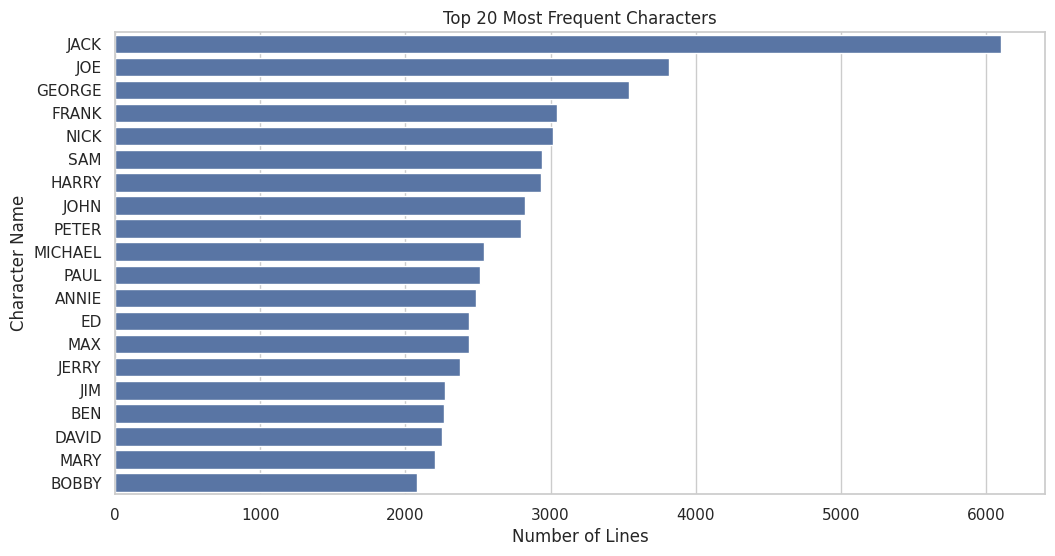

In [23]:
# Combine character_1 and character_2 to find most frequent characters
character_counts = pd.concat([df['character_1'], df['character_2']]).value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=character_counts.values, y=character_counts.index)
plt.title('Top 20 Most Frequent Characters')
plt.xlabel('Number of Lines')
plt.ylabel('Character Name')
plt.show()


Jack leads significantly with over 6,000 lines, followed by Joe and George, who both have under 4,000 lines. The distribution suggests that a few characters dominate the dataset, which may indicate that these characters are central to many conversations. The model will likely need to handle frequent interactions involving these high-volume characters, ensuring it can respond consistently and contextually to their dialogues.

<ipython-input-24-478cc78a1349>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")


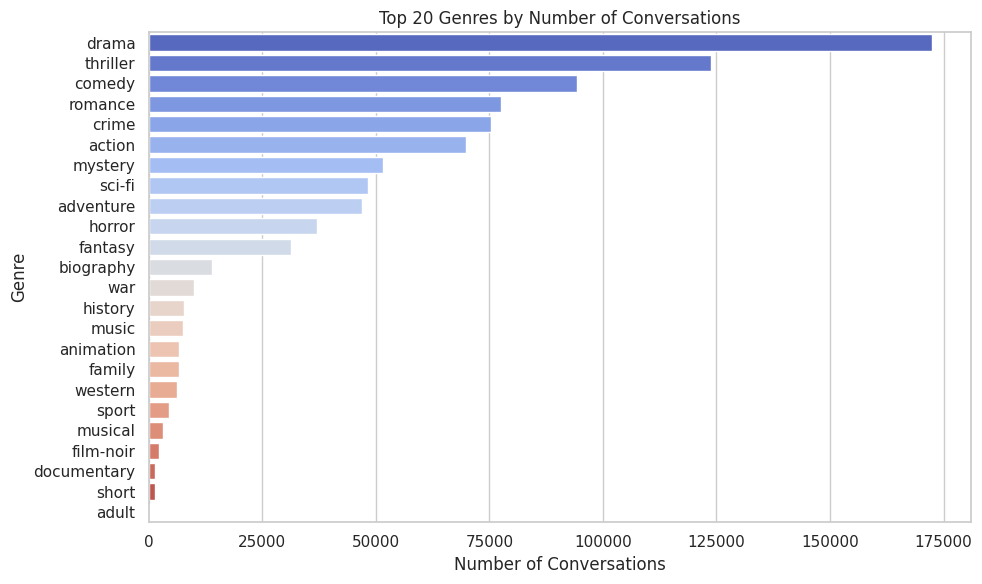

In [24]:
# Convert the genre strings to actual lists
df['genre'] = df['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 1: Explode the 'genre' column so each genre gets its own row
df_exploded = df.explode('genre')

# Step 2: Count the occurrences of each genre
#genre_counts = df_exploded['genre'].value_counts().head(20)  # Limit to top 20 genres
genre_counts = df_exploded['genre'].value_counts() # Limit to top 20 genres

# Step 3: Plot the genre distribution as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")
plt.title('Top 20 Genres by Number of Conversations')
plt.xlabel('Number of Conversations')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


Drama, thriller, and comedy dominate the list, with drama leading by a significant margin, followed by thriller. These three genres make up the majority of conversations, indicating that the dataset skews toward emotionally intense and suspenseful dialogue. The model will need to adapt to different tones and conversation styles, especially handling serious and suspenseful conversations more frequently than others. Other genres like romance and crime also have a notable presence, adding further variety to the interactions.

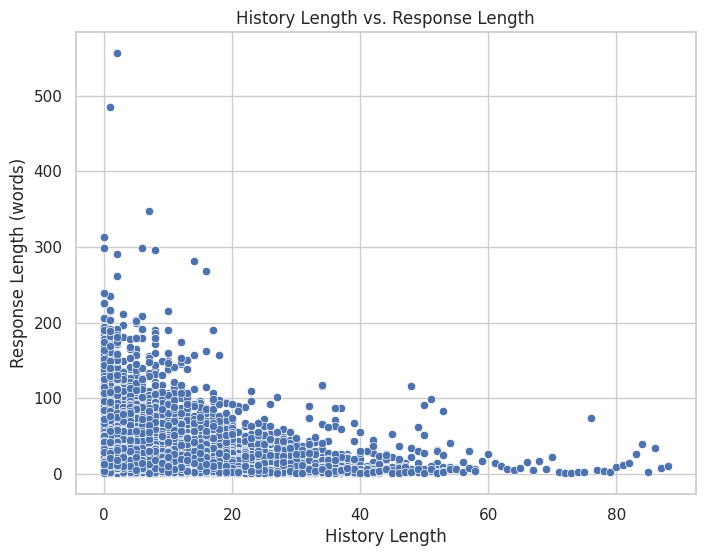

In [25]:
# Add a column for response length
df['response_length'] = df['response'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.scatterplot(x='history_length', y='response_length', data=df)
plt.title('History Length vs. Response Length')
plt.xlabel('History Length')
plt.ylabel('Response Length (words)')
plt.show()

# need to make sure this is words and not characters

The scatter plot shows an inverse relationship between history length and response length. At shorter history lengths (0–10), responses tend to be longer, with some reaching up to 500 words, particularly in the earliest exchanges. As the history length increases, response lengths shorten significantly, especially beyond 20 turns, where most responses fall below 50 words. This suggests that conversations start with more detailed responses but become more concise as shared context develops. Outliers with long responses occasionally appear mid-conversation but are less frequent at longer history lengths. The chatbot should adapt to these patterns by providing more detailed responses at the start of conversations and becoming more concise as the dialogue progresses.


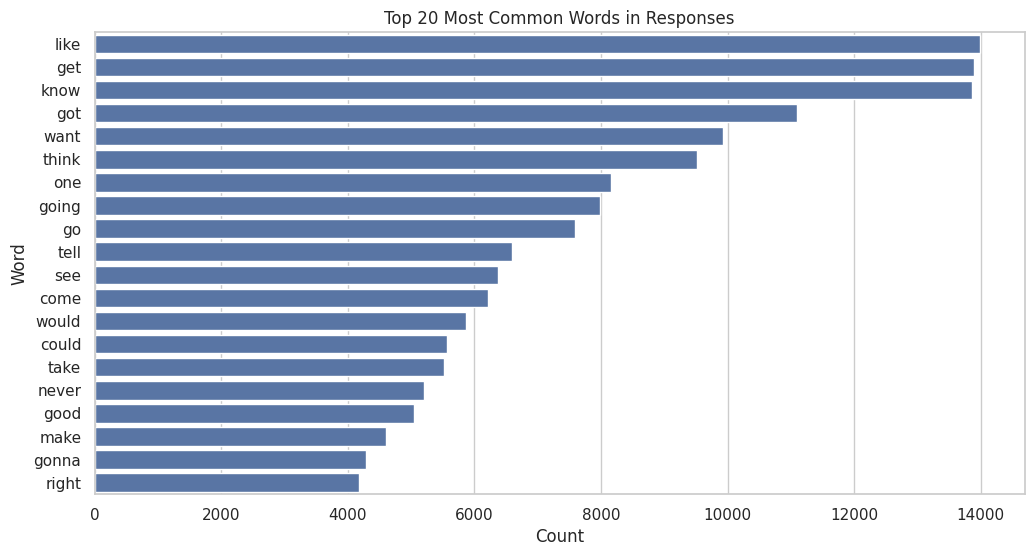

In [26]:
stop_words = set(stopwords.words('english'))

# Combine all responses into one string
all_responses = ' '.join(df['response'].tolist())

# Tokenize and remove stop words
words = [word.lower() for word in all_responses.split() if word.isalpha() and word.lower() not in stop_words]

word_counts = Counter(words).most_common(20)

# Convert to DataFrame for plotting
words_df = pd.DataFrame(word_counts, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=words_df)
plt.title('Top 20 Most Common Words in Responses')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


This bar chart displays the Top 20 most common words found in responses after removing stopwords. Words like "like," "get," and "know" are the most frequent, indicating that the conversations often involve casual, everyday dialogue. Many of the words, such as "want," "think," and "going," suggest that a significant portion of the conversations are centered around decision-making and opinions. The frequency of these basic verbs and pronouns highlights the conversational nature of the dataset.

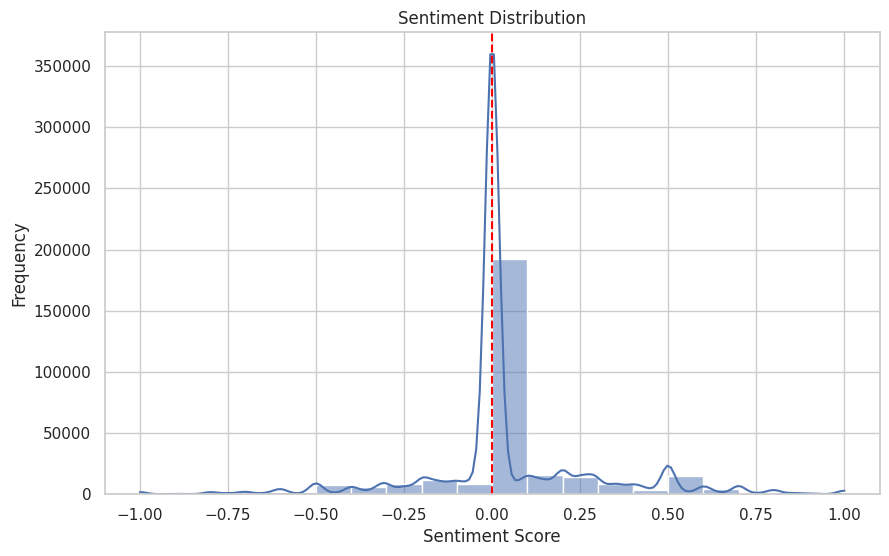

In [27]:

# Plotting the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--')  # Add a vertical line at sentiment = 0 for reference
plt.show()


The data primarily deals with neutral dialogues. While strong emotions are present, they are less frequent, so the model should prioritize neutral sentiment understanding with occasional adjustments for emotional responses.

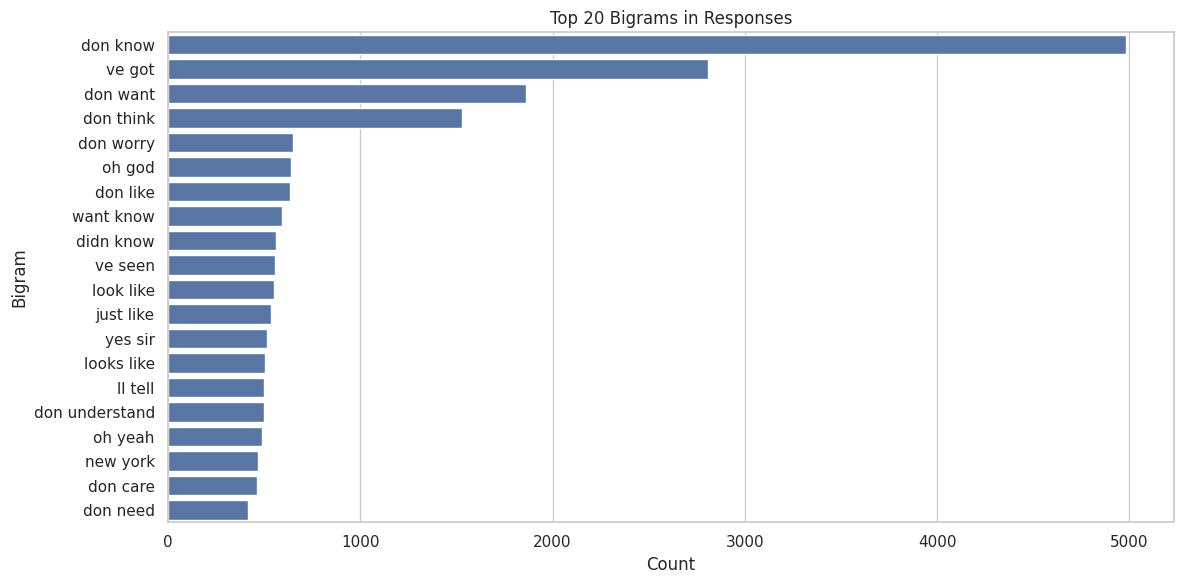

In [28]:
# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['response'])
bigram_counts = {word: count for word, count in zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)}

# Get the top 20 bigrams
top_bigrams = Counter(bigram_counts).most_common(20)

# Convert to DataFrame for plotting
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

# Plot the top 20 bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='bigram', data=bigram_df)
plt.title('Top 20 Bigrams in Responses')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()


The frequent appearance of these common phrases suggests that the dataset is filled with casual, informal speech, which is typical for movie dialogues. The model will need to handle such conversational patterns, particularly those involving negative expressions and common phrases about knowledge or intention.

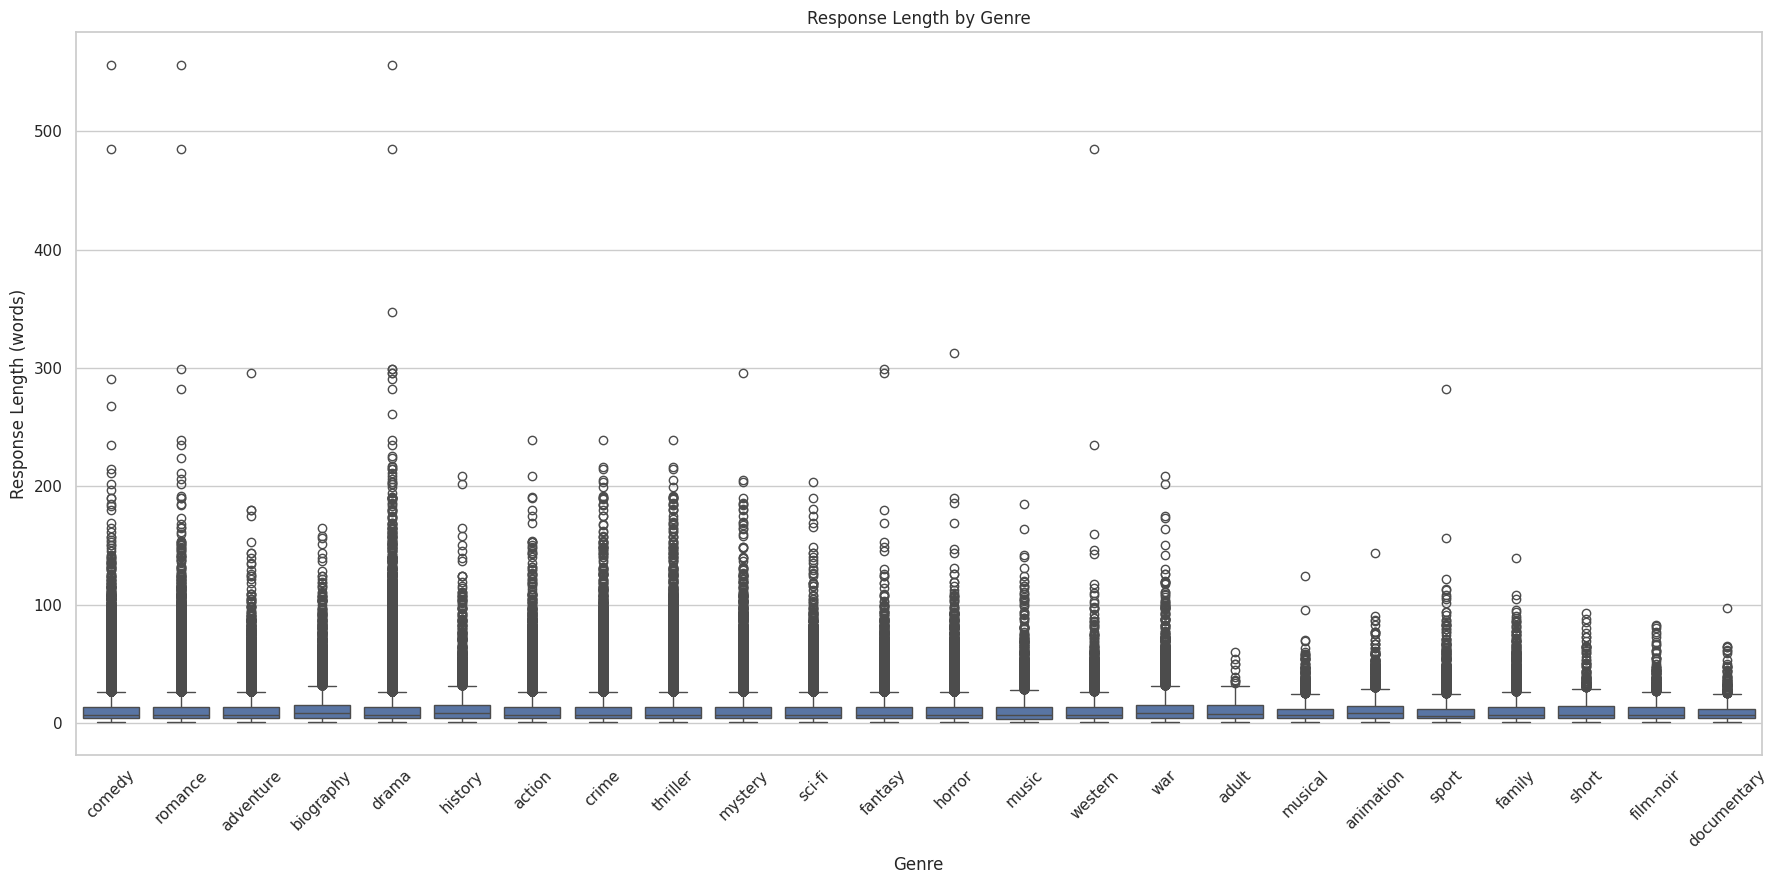

In [29]:
# Reset the index after exploding to avoid issues with duplicate indices
df_exploded = df.explode('genre').reset_index(drop=True)

plt.figure(figsize=(18, 9))
sns.boxplot(x='genre', y='response_length', data=df_exploded)
plt.title('Response Length by Genre')
plt.xlabel('Genre')
plt.ylabel('Response Length (words)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The model will need to handle both short responses (which dominate the dataset) and occasional long responses that vary by genre. The presence of long outliers in certain genres like drama and history suggests that more emotionally or narratively complex genres may require more detailed and nuanced responses.

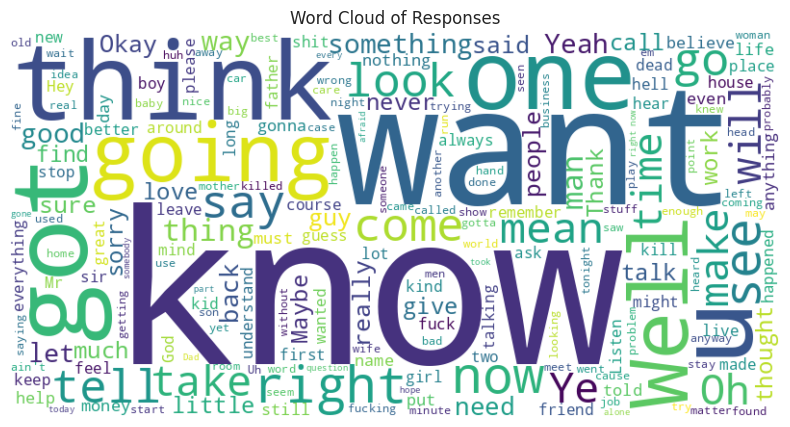

In [30]:
# Combine all responses into one string
all_responses = ' '.join(df['response'].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_responses)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Responses')
plt.show()


This word cloud highlights the most common words in responses, with terms like "know," "think," and "want" standing out. These words suggest that many dialogues involve expressions of thought, desire, or action. The chatbot will need to handle everyday conversational language, focusing on these common themes in dialogue.

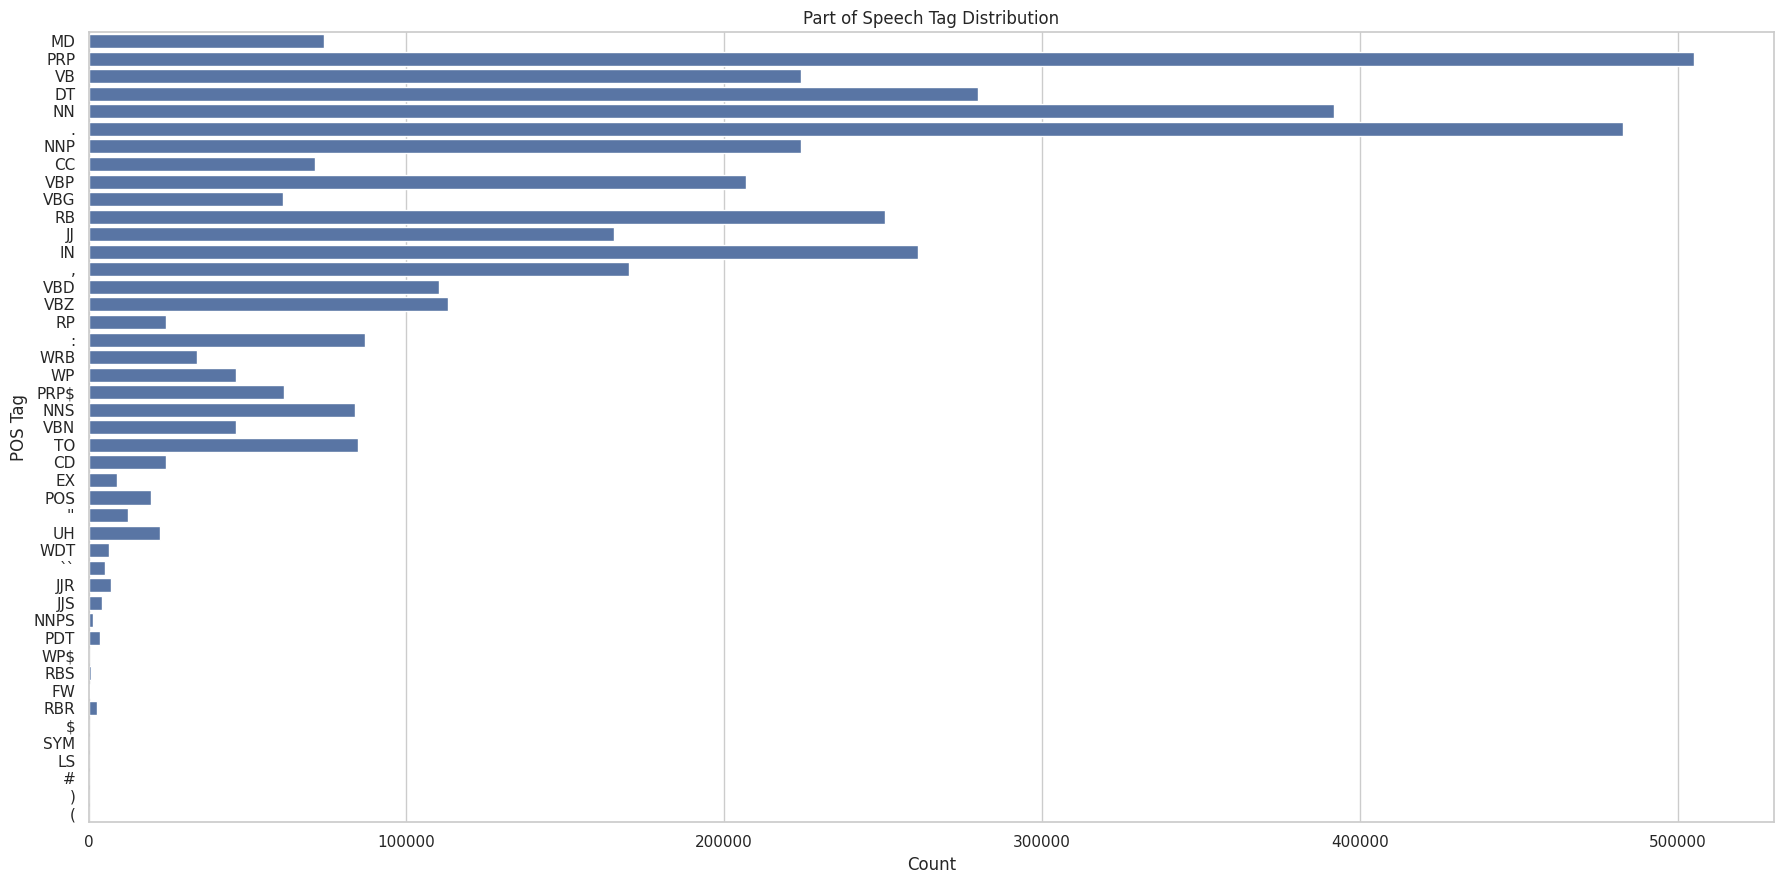

In [31]:
# Example of tagging one response
df['pos_tags'] = df['response'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

# Count the frequency of each POS tag
pos_counts = Counter([tag for tags in df['pos_tags'] for _, tag in tags])

# Convert to DataFrame for plotting
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS', 'count'])

# Plot the POS tag distribution
plt.figure(figsize=(18, 9))
sns.barplot(x='count', y='POS', data=pos_df)
plt.title('Part of Speech Tag Distribution')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.tight_layout()
plt.show()

# Drop the 'pos_tags' column after plotting
df.drop(columns=['pos_tags'], inplace=True)


The **Part of Speech (POS) Tag Distribution** graph highlights the dominance of nouns (NN), verbs (VB), and pronouns (PRP) in the dataset, suggesting a strong focus on actions and entities in the dialogues. Proper nouns (NNP) also appear frequently, indicating a focus on specific names and entities. The diversity of POS tags, including adjectives, conjunctions, and determiners, reflects the varied linguistic structure in the conversations.

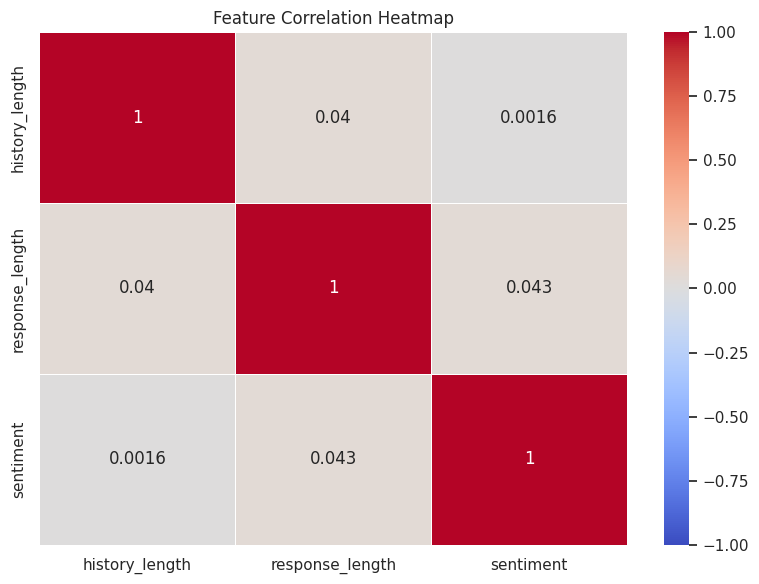

In [33]:
# Select numerical columns (including any other numeric features like sentiment, response length, etc.)
numerical_columns = ['history_length', 'response_length', 'sentiment']  # Add more columns as needed

# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


The Feature Correlation Heatmap shows weak correlations between the features in the dataset: history length, response length, and sentiment. The correlation between history length and response length is minimal at 0.047, indicating that longer conversation histories do not significantly influence response lengths. The correlation between history length and sentiment is nearly negligible at 0.0087, suggesting that sentiment is independent of conversation length. Overall, the heatmap indicates that these features are largely uncorrelated.

In [32]:
df.head()

,movie_id,character_1,character_2,conversation_history,history_length,response,genre,sentiment,response_length
0,m0,CAMERON,BIANCA,[[START]],0,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,"[comedy, romance]",0.411111,22
1,m0,BIANCA,CAMERON,[Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.],1,"Well, I thought we'd start with pronunciation, if that's okay with you.","[comedy, romance]",0.500000,12
2,m0,CAMERON,BIANCA,"[Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again., Well, I thought we'd start with pronunciation, if that's okay with you.]",2,Not the hacking and gagging and spitting part. Please.,"[comedy, romance]",0.000000,9
3,m0,BIANCA,CAMERON,"[Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again., Well, I thought we'd start with pronunciation, if that's okay with you., Not the hacking and gagging and spitting part. Please.]",3,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,"[comedy, romance]",0.250000,12
4,m0,CAMERON,BIANCA,[[START]],0,You're asking me out. That's so cute. What's your name again?,"[comedy, romance]",0.500000,11


### Exploratory Data Analysis (EDA) Summary:

The EDA on the dataset revealed several key insights about the structure, content, and characteristics of the dialogues. Here are the major takeaways:

1. **Conversation Length**: 
   - The majority of conversations start fresh, with **history lengths** of 0 and 1 dominating the dataset. These indicate interactions that rely on minimal context, but there is still a significant portion of longer dialogues, especially those extending beyond 10 turns. 
   - The average **response length** tends to decrease as the history length increases, suggesting that shorter replies become more common as conversations progress.

2. **Frequent Characters and Words**:
   - The most frequent characters (e.g., **JACK**, **JOE**) dominate a large proportion of the dialogues, reflecting an imbalance in character distribution.
   - Common words in responses include conversational and action-driven terms like **"know"**, **"want"**, and **"got"**, which highlight the interactive and intention-focused nature of the dialogues. Informal and casual language, such as **"gonna"**, suggests that a chatbot must handle colloquial speech.

3. **Genres and Context**:
   - The top genres by number of conversations are **drama**, **thriller**, and **comedy**, indicating that a wide range of emotional, suspenseful, and humorous tones are present in the dialogues. The chatbot will need to switch between different genres, adapting to the respective tones and conversational flows.
   - Response lengths vary across genres, with **drama** and **biography** having longer responses, while **action** and **thriller** tend to be more concise. This implies that the chatbot must be capable of understanding and adjusting its response length based on the genre or conversation context.

4. **Part-of-Speech (POS) Distribution**:
   - The dataset is rich in proper nouns (NNP) and personal pronouns (PRP), indicating that the chatbot must handle specific references to people, places, and objects, as well as interactive exchanges between characters. Action-oriented verbs and adjectives further emphasize that dialogues revolve around both descriptions and dynamic interactions.
   
5. **Feature Correlation**:
   - The correlation between **history length**, **response length**, and **sentiment** is very weak, indicating that none of these features strongly influence each other. This suggests that the chatbot will need to handle each feature independently, focusing on generating meaningful responses based on content rather than relying on simplistic assumptions about length or sentiment.

---

### Recommended GenAI Model: GPT for Multi-Turn Conversations

Given the goal of building a chatbot that can carry out **multi-turn conversations**, **adapt to context**, and **handle a variety of topics**, the **GPT (Generative Pre-trained Transformer)** model is the most suitable choice. Here’s why:

1. **Multi-Turn Dialogue Capability**:
   - **GPT** is inherently designed to manage sequential text generation, making it highly effective at handling multi-turn conversations. It can retain context from previous turns in a conversation, allowing it to generate coherent, contextually appropriate responses over long interactions, which is crucial for the chatbot’s goal of sustaining conversations across multiple exchanges.

2. **Adaptability to Context**:
   - **GPT’s transformer architecture** enables it to process large amounts of data and learn complex dependencies within conversations. It can adapt to various conversational contexts—whether it’s switching between emotional tones in **drama** or fast-paced exchanges in **action** or **thriller**. This flexibility allows GPT to understand and react appropriately to different genres and topics that the chatbot will encounter.

3. **Handling a Variety of Topics**:
   - **GPT** has been trained on extensive datasets covering diverse subjects, enabling it to handle a wide range of topics—from casual, informal exchanges to more serious, intellectual discussions. The model can shift between **informal language** (as seen in the dataset) and more formal interactions, ensuring the chatbot can respond appropriately in any scenario.

4. **Natural Language Understanding**:
   - GPT's language modeling capabilities allow it to generate responses that feel natural and human-like. This is critical, as the dataset includes casual speech, emotional content, and descriptive dialogue. GPT’s ability to understand subtleties in language, such as emotions, humor, and intentions, makes it an ideal choice for maintaining realistic and engaging conversations.

5. **Scalability and Fine-Tuning**:
   - **GPT** can be fine-tuned on the specific dataset from the Cornell Movie Dialogue Corpus. By doing so, it can better capture the nuances of the dataset, such as common phrases, genre-specific language, and character interactions, ensuring that the chatbot provides responses that are not only accurate but also contextually relevant.

6. **Handling of Colloquial Speech and Informal Interactions**:
   - Given that a large portion of the dataset includes informal language (e.g., **"gonna"**, **"okay"**, **"yeah"**), GPT’s ability to process and generate informal, conversational speech will ensure the chatbot feels natural in its responses. It can smoothly integrate casual phrases into its dialogue, making interactions more fluid and engaging.

---

### Conclusion:
The EDA reveals that the dataset contains a wide range of conversational patterns, varying in length, tone, and subject matter. **GPT** is the best model to build a chatbot capable of handling these complexities. Its strength in managing multi-turn conversations, adapting to diverse contexts, and generating human-like responses across various topics makes it the ideal choice for creating a chatbot that can engage users in meaningful and contextually aware conversations.


# Dataset Creation

In [38]:
import time
from tqdm import tqdm
import re

In [34]:
# Define the file paths
lines_file = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/Cornell_Movie_Dialogue_Corpus/movie_lines.txt"
conversation_file = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/Cornell_Movie_Dialogue_Corpus/movie_conversations.txt"

# Read the lines file with specified encoding
lines = pd.read_csv(lines_file, sep=r'\s*\+\+\+\$\+\+\+\s*', header=None, engine='python', encoding='ISO-8859-1')
lines.columns = ['line_id', 'character_id', 'movie_id', 'character', 'text']

# Read the conversations file with specified encoding
conversations = pd.read_csv(conversation_file, sep=r'\s*\+\+\+\$\+\+\+\s*', header=None, engine='python', encoding='ISO-8859-1')
conversations.columns = ['character1_id', 'character2_id', 'movie_id', 'utterance_ids']

# Display the first few rows of each DataFrame
print(lines.head())
print(conversations.head())

  line_id character_id movie_id character          text
0   L1045           u0       m0    BIANCA  They do not!
1   L1044           u2       m0   CAMERON   They do to!
2    L985           u0       m0    BIANCA    I hope so.
3    L984           u2       m0   CAMERON     She okay?
4    L925           u0       m0    BIANCA     Let's go.
  character1_id character2_id movie_id                     utterance_ids
0            u0            u2       m0  ['L194', 'L195', 'L196', 'L197']
1            u0            u2       m0                  ['L198', 'L199']
2            u0            u2       m0  ['L200', 'L201', 'L202', 'L203']
3            u0            u2       m0          ['L204', 'L205', 'L206']
4            u0            u2       m0                  ['L207', 'L208']


In [35]:
# Function to clean the text
def clean_text(text):
    # Retain specific punctuation and remove others
    text = re.sub(r"[^\w\s.!?'’]", '', text)  # Keep punctuation and apostrophes
    text = text.strip()  # Strip whitespace
    text = ' '.join(text.split())  # Normalize whitespace
    return text

In [36]:
def create_dataset(conversations, lines):
    # Create a dictionary for fast line access
    line_dict = dict(zip(lines['line_id'], lines['text']))

    dataset = []

    # Use tqdm to show progress
    for _, row in tqdm(conversations.iterrows(), total=conversations.shape[0], desc="Processing conversations"):
        utterance_ids = row['utterance_ids'].strip('[]').replace("'", "").split(', ')

        # Initialize conversation history
        conversation_history = []

        for utterance_id in utterance_ids:
            # Access the text from the dictionary
            text = line_dict.get(utterance_id)
            if isinstance(text, str):  # Ensure text is a string
                # Add the current line to the history with [SEP] separator between turns
                conversation_history.append(f"{text} [SEP]")

                # Create a record with the current history and response
                if len(conversation_history) > 1:
                    # The last entry is the response
                    response = conversation_history[-1]
                    history = conversation_history[:-1]

                    # Ensure that the history is made of strings
                    dataset.append({
                        'conversation_history': ' '.join(h for h in history if isinstance(h, str)),
                        'response': response.strip(' [SEP]')  # Remove the last [SEP] in the response
                    })

    return pd.DataFrame(dataset)

In [39]:
# Create the dataset
start_time = time.time()
chatbot_dataset = create_dataset(conversations, lines)
end_time = time.time()

# Clean the conversation history and responses, replacing the original columns
chatbot_dataset['conversation_history'] = chatbot_dataset['conversation_history'].apply(clean_text)
chatbot_dataset['response'] = chatbot_dataset['response'].apply(clean_text)

# Display the first few rows of the cleaned dataset
# print(chatbot_dataset[['conversation_history', 'response']].head())
print(f"Execution Time: {end_time - start_time} seconds")

Processing conversations: 100%|██████████| 83097/83097 [00:04<00:00, 17723.16it/s]


Execution Time: 5.002771377563477 seconds


In [40]:
chatbot_dataset.head()

,conversation_history,response
0,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad. Again. SEP,Well I thought we'd start with pronunciation if that's okay with you.
1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad. Again. SEP Well I thought we'd start with pronunciation if that's okay with you. SEP,Not the hacking and gagging and spitting part. Please.
2,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad. Again. SEP Well I thought we'd start with pronunciation if that's okay with you. SEP Not the hacking and gagging and spitting part. Please. SEP,Okay... then how 'bout we try out some French cuisine. Saturday? Night?
3,You're asking me out. That's so cute. What's your name again? SEP,Forget it.
4,No no it's my fault we didn't have a proper introduction SEP,Cameron.


Adding SEP Token due to previous testing that showed it helped the model understand the break in conversation and who turn is who.

In [ ]:
chatbot_dataset.to_csv("/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/dataset.csv", index=False)